**Objetivo:** Estudar como as linhas espectrais da molécula de HCl na banda 2-0 se alargam em função da temperatura.


 **1.** Verificar se os espectros simulados pelo Hitran provê os mesmos coeficientes de auto-alargamento em função da pressão estudados durante a graduação.

 **2.** Simular espectros com as mesmas pressões, mas em temperaturas diferentes e verificar o que acontece com os coeficientes de auto-alargamento em cada temperatura
 
 **3.** Fixar uma pressão e verificar como esse coeficiente varia somente na temperatura.

 **4.** Estudar uma maneira de determinar a dependência entre pressão e temperatura.

 **5.** Modelar matematicamente em termos de temperatura e pressão

 **6.** Validar esse modelo em dados reais

 **7.** Desenvolver modelos de Machine Learning para processamento de espectros 

# Importando pacotes

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

from BroadeningProcessing import broadeningprocessing




mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = (12,6)

# Simulando e processando espectros

Uma banda espectral é formada por linhas/raias espectrais, essas linhas são provenientes das transições de energias rotacionais em uma molécula. Essas transições podem ser categorizadas por Ramas denominadas por rama R, rama P ou  rama Q. No caso da banda 2-0 do HCl, temos somente as Ramas R e P. Cada linha, além da categorização da rama, tem também um valor de J associado, para o HCl temos:

R = 0, 1, 2, 3, 4...

P = 1, 2, 3, 4...

Além do valor de J, podemos introduzir uma outra variável denotada por m, onde

m = -J, se for rama P,

m = J + 1, se for rama R

Ao simularmos um espectro, é necessário aplicarmos um pré-processamento para organizarmos os dados obtidos, visamos nessa parte categorizar as transições (R/P) e definir seus valores de J e m. 

Após a organização das linhas, precisaremos obter os coeficientes de auto-alargamento, e para isso será necessário obter a largura de cada raia espectral. Esse parâmetro será obtido mediante o ajuste não linear de cada linha espectral pelo perfil de Voigt. No meu tcc eu demonstrei que o perfil de Voigt é o melhor perfil que se ajusta nas linhas do HCl, além disso, o perfil de Voigt é um grande coringa, pois leva em consideração os efeitos simultâneos de colisão e efeito doppler.

**Tarefas:**

**1.** Identificar as raias espectrais

**2.** Categorizar as linhas em rama P ou rama R

**3.** Indicar a numeração de cada linha referente  a sua rama

**4.** Separar a raia do espectro.

**5.** Ajustar a linha utilizando o perfil de Voigt.

**6.** Armazenar todos os parâmetros obtidos do ajuste em um dataset.

**7.** Fazer isso para espectros em diferentes pressões e temperaturas.


obs: As simulações dos espectros, atribuição de raias e ajuste das linhas para obtenção de parâmetros foi feito através do script /src/main.py e se encontra no diretório /database

# Carregando dataset com os parâmetros de cada linha

In [2]:
lines35 = pd.read_csv('../database/lines_h35cl_c2.csv')

# Breve EDA $$H^{35}Cl$$

In [3]:
lines35.head()

,wavenumber,absorption,branch,j,m,pressure,temperature,evals,npoints,r2,...,center,center_std,sigma,sigma_stderr,gamma,gamma_stderr,fwhm,fwhm_stderr,height,height_stderr
0,5406.878654,0.030915,P,10,-10,0.1,293,26,209,0.999981,...,5406.878621,0.000016,0.004736,0.000020,0.009571,0.000017,0.024507,0.000016,0.030931,0.000014
1,5438.054654,0.066758,P,9,-9,0.1,293,36,240,0.999999,...,5438.055121,0.000003,0.004795,0.000005,0.011187,0.000004,0.027320,0.000004,0.066863,0.000007
2,5468.143654,0.127785,P,8,-8,0.1,293,21,275,0.999999,...,5468.143779,0.000003,0.004896,0.000005,0.013024,0.000003,0.030655,0.000003,0.127821,0.000009
3,5497.129654,0.206848,P,7,-7,0.1,293,31,331,0.999405,...,5497.129887,0.000081,0.000955,0.000803,0.017116,0.000108,0.034389,0.000111,0.209684,0.000476
4,5524.999654,0.289702,P,6,-6,0.1,293,47,405,0.999999,...,5524.999401,0.000003,0.005207,0.000008,0.019684,0.000005,0.043093,0.000004,0.289939,0.000022


In [4]:
# sem valores nulos
lines35.isna().sum()

wavenumber          0
absorption          0
branch              0
j                   0
m                   0
pressure            0
temperature         0
evals               0
npoints             0
r2                  0
amplitude           0
amplitude_stderr    0
center              0
center_std          0
sigma               0
sigma_stderr        0
gamma               0
gamma_stderr        0
fwhm                0
fwhm_stderr         0
height              0
height_stderr       0
dtype: int64

In [5]:
# sem valores duplicados
lines35.duplicated().sum()

np.int64(0)

In [6]:
# Em muitos trabalhos utiliza-se a meia largura à meia altura (hwhm) ao invés da largura total à meia altura (fhwm)
# hwhm = fwhm/2

lines35['hwhm'] = lines35['fwhm'] / 2 


print(f" {lines35.shape[0]} linhas foram ajustadas com {lines35.shape[1]} parâmetros obtidos, são eles:\n")
for index, param in enumerate(lines35.columns):
    print(f"{index} - {param}")

 779 linhas foram ajustadas com 23 parâmetros obtidos, são eles:

0 - wavenumber
1 - absorption
2 - branch
3 - j
4 - m
5 - pressure
6 - temperature
7 - evals
8 - npoints
9 - r2
10 - amplitude
11 - amplitude_stderr
12 - center
13 - center_std
14 - sigma
15 - sigma_stderr
16 - gamma
17 - gamma_stderr
18 - fwhm
19 - fwhm_stderr
20 - height
21 - height_stderr
22 - hwhm


In [7]:
# As mesmas pressões foram reproduzidas em diferentes temperaturas 

lines35.groupby('temperature')['pressure'].unique().to_frame()

,pressure
temperature,
293,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
295,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
300,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
315,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
350,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"
373,"[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]"


## **Análise dos ajustes das raias**

Objetivo: Quantificar a qualidade dos ajustes das raias espectrais

In [8]:
lines35['r2'].describe()

count    779.000000
mean       0.999978
std        0.000163
min        0.998030
25%        0.999999
50%        1.000000
75%        1.000000
max        1.000000
Name: r2, dtype: float64

**Insight:** 

Ajustes bons com R² superiores à 0.9. O pior ajuste teve um R² de 0.938 e o melhor ajuste teve o R² máximo. Em mediana tivemos um R² de 0.9999 e 0.9988 em média. 

25% das linhas tiveram seu R² abaixo de 0.999841.

O valor da média é influenciado para baixo devido aos poucos exemplos com R² menores que 0.99.

Em suma, os ajustes ficaram muito bons.



## Análise do alargamento das linhas espectrais

<Axes: xlabel='hwhm', ylabel='Density'>

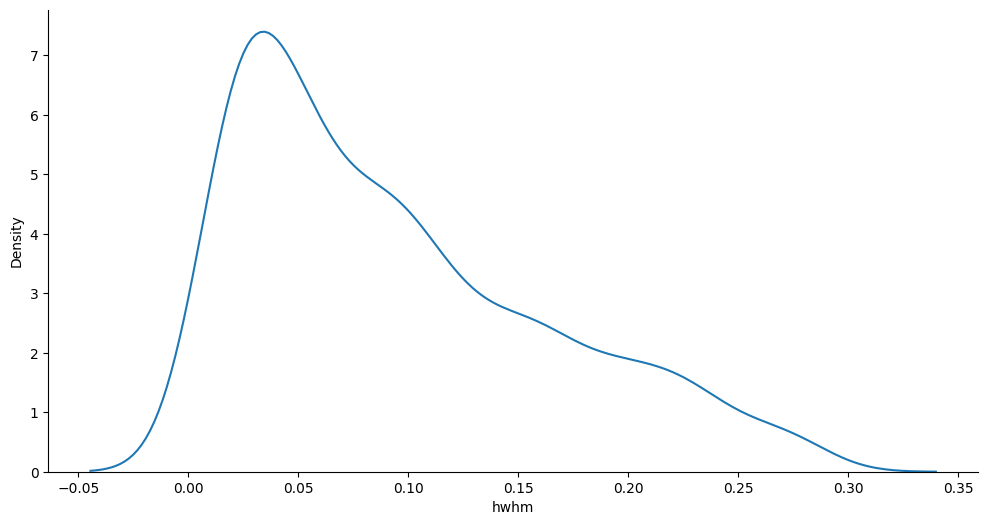

In [9]:
lines35['hwhm'].describe()

sns.kdeplot(data = lines35, x='hwhm')

In [10]:
sb = pd.DataFrame()
for temperature in lines35['temperature'].unique():
    print(temperature)
    line_temp_cte = lines35.query(f'temperature == {temperature}')

    result = broadeningprocessing.selfBroadeningPressure(line_temp_cte)
    sb = pd.concat([sb,result],axis=0)


293
295
300
315
350
373


In [11]:
sb['half_slope'] = sb['slope'] / 2

<Axes: xlabel='m', ylabel='slope'>

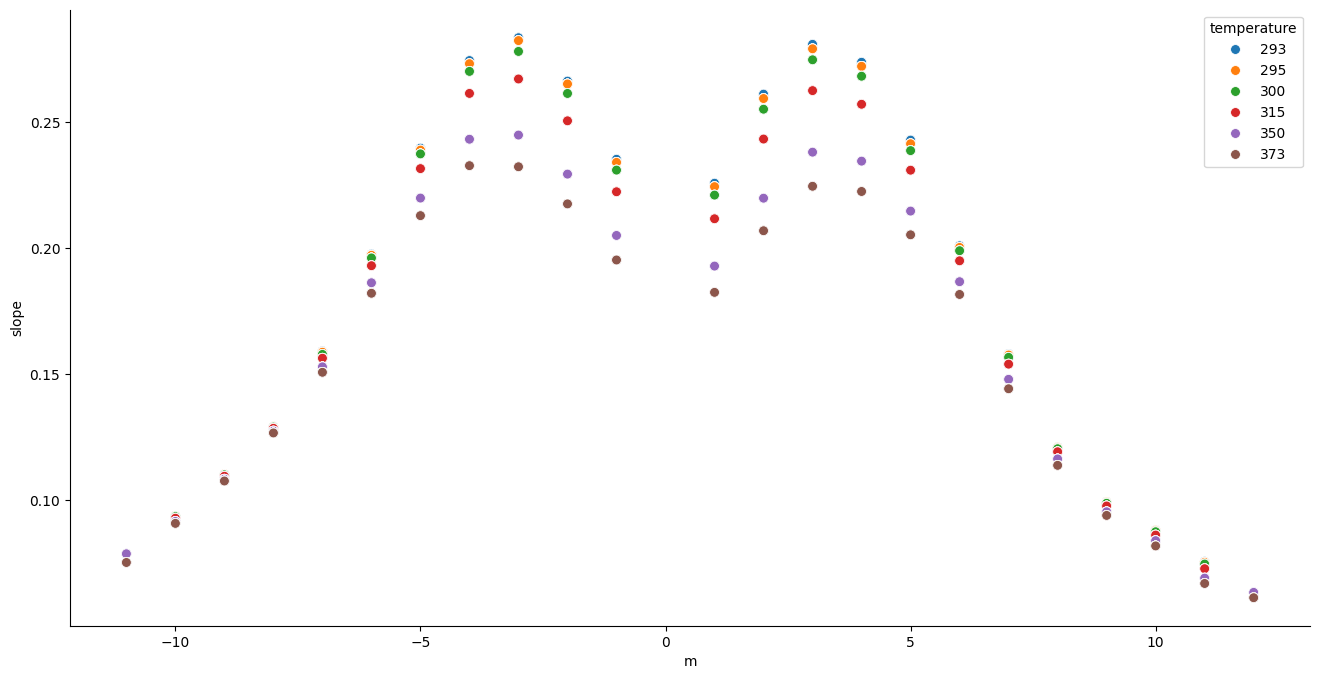

In [12]:
plt.figure(figsize=(16,8))
sns.scatterplot(data = sb, x='m',y='slope', hue='temperature', palette= 'tab10', s=50)

<Axes: xlabel='temperature', ylabel='half_slope'>

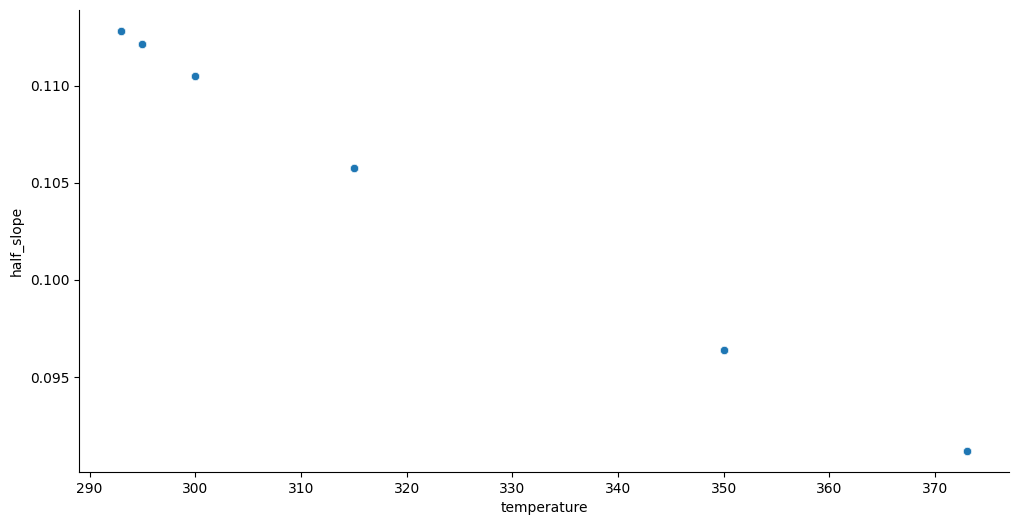

In [13]:
sns.scatterplot(data = sb.query('m == 1'), x='temperature',y='half_slope')

In [14]:
lines35.query('temperature == 293 and pressure == 0.4')

,wavenumber,absorption,branch,j,m,pressure,temperature,evals,npoints,r2,...,center_std,sigma,sigma_stderr,gamma,gamma_stderr,fwhm,fwhm_stderr,height,height_stderr,hwhm
42,5406.878654,0.035934,P,10,-10,0.4,293,36,771,1.000000,...,1.830505e-07,0.004731,0.000001,0.038402,3.870768e-07,0.078500,4.796543e-07,0.035937,1.489290e-07,0.039250
43,5438.054654,0.075314,P,9,-9,0.4,293,43,900,1.000000,...,1.557602e-07,0.004811,0.000001,0.044927,3.460027e-07,0.091361,4.478824e-07,0.075322,2.458981e-07,0.045680
44,5468.143654,0.140423,P,8,-8,0.4,293,41,1047,1.000000,...,2.451672e-07,0.005007,0.000003,0.052377,5.722424e-07,0.106160,7.674794e-07,0.140422,6.634278e-07,0.053080
45,5497.129654,0.221451,P,7,-7,0.4,293,47,1278,1.000000,...,2.816768e-07,0.005481,0.000004,0.063912,7.016990e-07,0.129208,9.485991e-07,0.221470,1.044031e-06,0.064604
46,5524.999654,0.303631,P,6,-6,0.4,293,51,1584,1.000000,...,3.953164e-07,0.006506,0.000006,0.079215,1.051034e-06,0.160005,1.411338e-06,0.303660,1.694653e-06,0.080003
47,5551.737654,0.375761,P,5,-5,0.4,293,72,1914,1.000000,...,5.912374e-07,0.008145,0.000009,0.095644,1.650474e-06,0.193332,2.170668e-06,0.375817,2.646508e-06,0.096666
48,5577.330654,0.428804,P,4,-4,0.4,293,49,2186,1.000000,...,8.191860e-07,0.009966,0.000012,0.109129,2.353542e-06,0.220934,3.056060e-06,0.428894,3.701465e-06,0.110467
49,5601.765654,0.461816,P,3,-3,0.4,293,69,2255,1.000000,...,9.990859e-07,0.011001,0.000014,0.112492,2.889345e-06,0.228142,3.740901e-06,0.461933,4.717503e-06,0.114071
50,5625.027654,0.446732,P,2,-2,0.4,293,59,2121,1.000000,...,9.228693e-07,0.010169,0.000013,0.105805,2.633913e-06,0.214481,3.401203e-06,0.446844,4.427794e-06,0.107240
51,5647.104654,0.322748,P,1,-1,0.4,293,53,1883,1.000000,...,5.710541e-07,0.007241,0.000009,0.094120,1.578546e-06,0.189885,2.092970e-06,0.322784,2.235917e-06,0.094942
